<a href="https://colab.research.google.com/github/Tandez/Computer_Vision/blob/main/BrainTumor_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')


import os
import torch
import matplotlib.pyplot as plt

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.ops import box_convert


os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

from engine import train_one_epoch, evaluate
import utils


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, data, transforms):
        self.root = root
        self.data = data
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(f'{root}/images/{data}'))))
        self.bbox = list(sorted(os.listdir(os.path.join(f'{root}/labels/{data}'))))

        # Assert same length

        if len(self.imgs) == len(self.bbox):
          pass
        else:
          temp_imgs = self.imgs[:]
          temp_bbox = self.bbox[:]
          for i in range(len(temp_imgs)):
            temp_imgs[i] = temp_imgs[i][:-4]

          for i in range(len(temp_bbox)):
            temp_bbox[i] = temp_bbox[i][:-4]


          self.errors = [x for x in temp_imgs if x not in set(temp_bbox)]
          self.errors2 = [x for x in temp_bbox if x not in set(temp_imgs)]


          for i in range(len(self.errors)):
            if self.errors[i] + '.jpg' in self.imgs:
              self.imgs.remove(self.errors[i] + '.jpg')

          for i in range(len(self.errors2)):
            if self.errors2[i] + '.txt' in self.bbox:
              self.bbox.remove(self.errors2[i] + '.txt')



    def __getitem__(self, idx):

      # Function to convert Yolo coordinates to Coco and scale them

        def yolobbox2bbox(x,y,w,h, image_size):
          x1, y1 = x-w/2, y-h/2
          x2, y2 = x+w/2, y+h/2
          return [x1 * image_size[0] , y1 * image_size[1] , x2 * image_size[0] , y2 * image_size[1]]

        img_path = os.path.join(f'{self.root}/images/{self.data}/{self.imgs[idx]}')
        img = read_image(img_path)
        box_path = os.path.join(f'{self.root}/labels/{self.data}/{self.bbox[idx]}')

        with open(box_path, "r") as file:
          data = file.read()

        labels = []
        boxes = []
        for i in data.split('\n'):
          labels.append(i[0])
          boxes.append(i[2:])

        boxes = [i.split(' ') for i in boxes]

        for i, line in enumerate(boxes):
          for j, value in enumerate(line):
            line[j] = float(value)

        image_size =  F.get_size(img)

        for i in range(len(boxes)):
          boxes[i] = yolobbox2bbox(boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3], image_size)


        labels = [eval(i) for i in labels]
        labels = torch.Tensor(labels)
        labels = labels.long()

        boxes = torch.Tensor(boxes)

        num_objs = len(labels)

        image_id = self.imgs[idx]
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Assume all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


Visualize Scans and Bounding Boxes

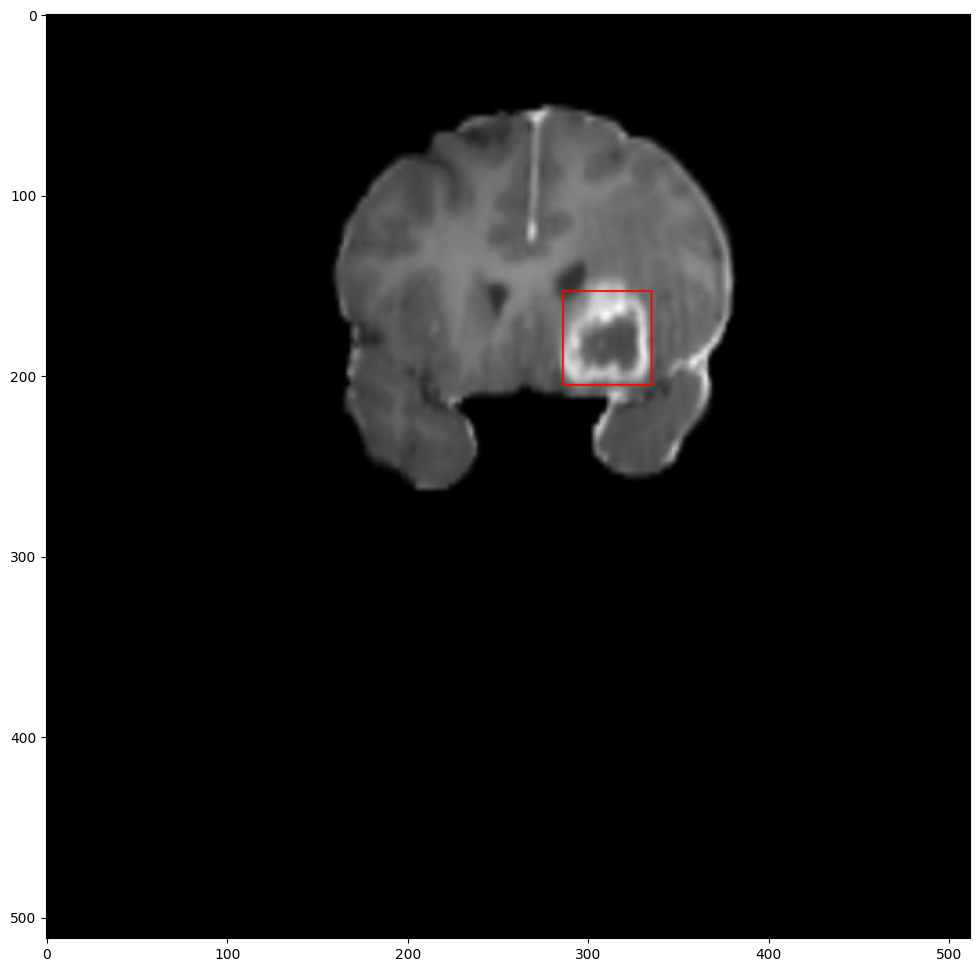

In [44]:
dataset_test = Dataset('drive/MyDrive/coronal_t1wce_2_class', 'test', get_transform(train=False))

boxes = dataset_test.__getitem__(50)[1]['boxes']
image = dataset_test.__getitem__(50)[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
output_image = draw_bounding_boxes(image, boxes, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))


In [6]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


    return model


Loading Data and Training Model

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 3

dataset_train = Dataset('drive/MyDrive/coronal_t1wce_2_class', 'train', get_transform(train=True))
dataset_valid = Dataset('drive/MyDrive/coronal_t1wce_2_class', 'train', get_transform(train=False))

indices = torch.randperm(len(dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-50])
dataset_valid = torch.utils.data.Subset(dataset_valid, indices[-50:])


data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)


model3 = get_model_instance_segmentation(num_classes)
model3.to(device)

params = [p for p in model3.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1)

num_epochs = 5

for epoch in range(num_epochs):

    train_one_epoch(model3, optimizer, data_loader, device, epoch, print_freq=20)

    lr_scheduler.step()

    evaluate(model3, data_loader_test, device=device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0]  [  0/104]  eta: 0:00:58  lr: 0.000053  loss: 0.2208 (0.2208)  loss_classifier: 0.0676 (0.0676)  loss_box_reg: 0.0821 (0.0821)  loss_objectness: 0.0680 (0.0680)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.5598  data: 0.1303  max mem: 1789
Epoch: [0]  [ 20/104]  eta: 0:00:33  lr: 0.001023  loss: 0.0763 (0.0966)  loss_classifier: 0.0305 (0.0399)  loss_box_reg: 0.0425 (0.0494)  loss_objectness: 0.0005 (0.0059)  loss_rpn_box_reg: 0.0010 (0.0014)  time: 0.3877  data: 0.0143  max mem: 1790
Epoch: [0]  [ 40/104]  eta: 0:00:24  lr: 0.001993  loss: 0.0907 (0.1001)  loss_classifier: 0.0363 (0.0431)  loss_box_reg: 0.0430 (0.0504)  loss_objectness: 0.0011 (0.0052)  loss_rpn_box_reg: 0.0008 (0.0013)  time: 0.3823  data: 0.0056  max mem: 1790
Epoch: [0]  [ 60/104]  eta: 0:00:17  lr: 0.002963  loss: 0.0606 (0.0895)  loss_classifier: 0.0250 (0.0391)  loss_box_reg: 0.0333 (0.0442)  loss_objectness: 0.0012 (0.0047)  loss_rpn_box_reg: 0.0009 (0.0014)  time: 0.4061  data: 0.0081  max mem: 1790


Saving model and runnig inference from saved model

In [12]:
torch.save(model3, 'drive/MyDrive/BrainTumorDetection_model')

In [23]:
model2 = torch.load('drive/MyDrive/BrainTumorDetection_model')

eval_transform = get_transform(train=False)


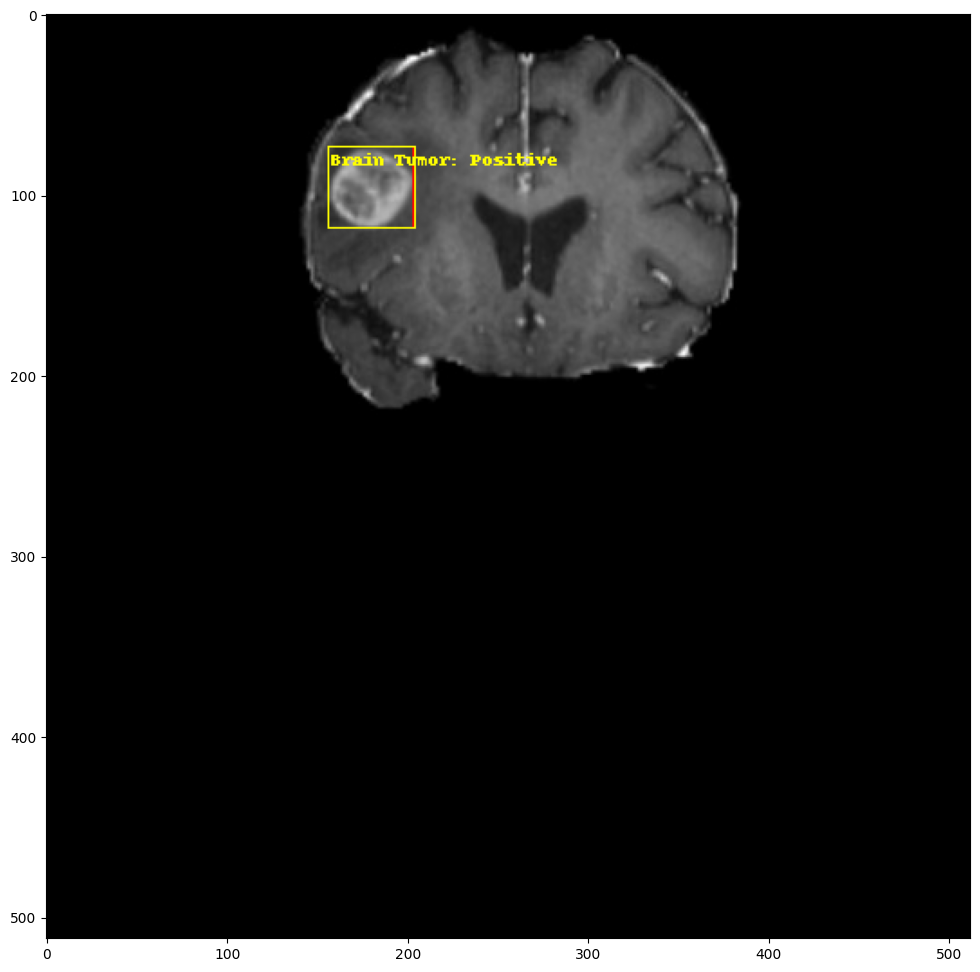

In [46]:
image = dataset_test.__getitem__(58)[0]
expected_boxes = dataset_test.__getitem__(58)[1]['boxes']
expected_labels = dataset_test.__getitem__(58)[1]['labels']


model2.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model2([x, ])
    pred = predictions[0]

colors=[]
colors = ['red'] * len(pred["boxes"])
colors.extend(['yellow'] * len(expected_boxes))

pred["boxes"] = torch.cat((pred["boxes"], expected_boxes.to(device)), 0)

pred["labels"] = torch.cat((pred["labels"], expected_labels.to(device)), 0)


labels = []
for i in pred["labels"]:
  if i == 1:
    labels.append('Positive')
  else:
    labels.append('Negative')

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"Brain Tumor: {label}" for label in labels]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred["boxes"], pred_labels, colors=colors)


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [47]:
pred_boxes

tensor([[156,  73, 203, 118],
        [156,  73, 204, 118]], device='cuda:0')

In [29]:
pred_labels

['Brain Tumor: Positive', 'Brain Tumor: Positive']